## Training 4a

In [1]:
seed=3
frac_train=0.25 
weight_decay = 1.0 #@param
freq_penalty_weight = 1e-3 

In [2]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
import tqdm.notebook as tqdm

import random
import time

# from google.colab import drive
from pathlib import Path
import pickle
import os

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "colab"
import plotly.graph_objects as go

from torch.utils.data import DataLoader

from functools import *
import pandas as pd
import gc

# import comet_ml
import itertools

## Support Functions

In [3]:
# A helper class to get access to intermediate activations (inspired by Garcon)
# It's a dummy module that is the identity function by default
# I can wrap any intermediate activation in a HookPoint and get a convenient 
# way to add PyTorch hooks
class HookPoint(nn.Module):
    def __init__(self):
        super().__init__()
        self.fwd_hooks = []
        self.bwd_hooks = []
    
    def give_name(self, name):
        # Called by the model at initialisation
        self.name = name
    
    def add_hook(self, hook, dir='fwd'):
        # Hook format is fn(activation, hook_name)
        # Change it into PyTorch hook format (this includes input and output, 
        # which are the same for a HookPoint)
        def full_hook(module, module_input, module_output):
            return hook(module_output, name=self.name)
        if dir=='fwd':
            handle = self.register_forward_hook(full_hook)
            self.fwd_hooks.append(handle)
        elif dir=='bwd':
            handle = self.register_backward_hook(full_hook)
            self.bwd_hooks.append(handle)
        else:
            raise ValueError(f"Invalid direction {dir}")
    
    def remove_hooks(self, dir='fwd'):
        if (dir=='fwd') or (dir=='both'):
            for hook in self.fwd_hooks:
                hook.remove()
            self.fwd_hooks = []
        if (dir=='bwd') or (dir=='both'):
            for hook in self.bwd_hooks:
                hook.remove()
            self.bwd_hooks = []
        if dir not in ['fwd', 'bwd', 'both']:
            raise ValueError(f"Invalid direction {dir}")
    
    def forward(self, x):
        return x

In [4]:
# Define network architecture
# I defined my own transformer from scratch so I'd fully understand each component 
# - I expect this wasn't necessary or particularly important, and a bunch of this 
# replicates existing PyTorch functionality

# Embed & Unembed
class Embed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_E = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_model))
    
    def forward(self, x):
        return torch.einsum('dbp -> bpd', self.W_E[:, x])

class Unembed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_U = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_vocab))
    
    def forward(self, x):
        return (x @ self.W_U)

# Positional Embeddings
class PosEmbed(nn.Module):
    def __init__(self, max_ctx, d_model):
        super().__init__()
        self.W_pos = nn.Parameter(torch.randn(max_ctx, d_model)/np.sqrt(d_model))
    
    def forward(self, x):
        return x+self.W_pos[:x.shape[-2]]

# LayerNorm
class LayerNorm(nn.Module):
    def __init__(self, d_model, epsilon = 1e-4, model=[None]):
        super().__init__()
        self.model = model
        self.w_ln = nn.Parameter(torch.ones(d_model))
        self.b_ln = nn.Parameter(torch.zeros(d_model))
        self.epsilon = epsilon
    
    def forward(self, x):
        if self.model[0].use_ln:
            x = x - x.mean(axis=-1)[..., None]
            x = x / (x.std(axis=-1)[..., None] + self.epsilon)
            x = x * self.w_ln
            x = x + self.b_ln
            return x
        else:
            return x

# Attention
class Attention(nn.Module):
    def __init__(self, d_model, num_heads, d_head, n_ctx, model):
        super().__init__()
        self.model = model
        self.W_K = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_Q = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_V = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_O = nn.Parameter(torch.randn(d_model, d_head * num_heads)/np.sqrt(d_model))
        self.register_buffer('mask', torch.tril(torch.ones((n_ctx, n_ctx))))
        self.d_head = d_head
        self.hook_k = HookPoint()
        self.hook_q = HookPoint()
        self.hook_v = HookPoint()
        self.hook_z = HookPoint()
        self.hook_attn = HookPoint()
        self.hook_attn_pre = HookPoint()

    def forward(self, x):
        k = self.hook_k(torch.einsum('ihd,bpd->biph', self.W_K, x))
        q = self.hook_q(torch.einsum('ihd,bpd->biph', self.W_Q, x))
        v = self.hook_v(torch.einsum('ihd,bpd->biph', self.W_V, x))
        attn_scores_pre = torch.einsum('biph,biqh->biqp', k, q)
        attn_scores_masked = torch.tril(attn_scores_pre) - 1e10 * (1 - self.mask[:x.shape[-2], :x.shape[-2]])
        attn_matrix = self.hook_attn(F.softmax(self.hook_attn_pre(attn_scores_masked/np.sqrt(self.d_head)), dim=-1))
        z = self.hook_z(torch.einsum('biph,biqp->biqh', v, attn_matrix))
        z_flat = einops.rearrange(z, 'b i q h -> b q (i h)')
        out = torch.einsum('df,bqf->bqd', self.W_O, z_flat)
        return out

# MLP Layers
class MLP(nn.Module):
    def __init__(self, d_model, d_mlp, act_type, model):
        super().__init__()
        self.model = model
        self.W_in = nn.Parameter(torch.randn(d_mlp, d_model)/np.sqrt(d_model))
        self.b_in = nn.Parameter(torch.zeros(d_mlp))
        self.W_out = nn.Parameter(torch.randn(d_model, d_mlp)/np.sqrt(d_model))
        self.b_out = nn.Parameter(torch.zeros(d_model))
        self.act_type = act_type
        # self.ln = LayerNorm(d_mlp, model=self.model)
        self.hook_pre = HookPoint()
        self.hook_post = HookPoint()
        assert act_type in ['ReLU', 'GeLU']
        
    def forward(self, x):
        x = self.hook_pre(torch.einsum('md,bpd->bpm', self.W_in, x) + self.b_in)
        if self.act_type=='ReLU':
            x = F.relu(x)
        elif self.act_type=='GeLU':
            x = F.gelu(x)
        x = self.hook_post(x)
        x = torch.einsum('dm,bpm->bpd', self.W_out, x) + self.b_out
        return x

# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model):
        super().__init__()
        self.model = model
        # self.ln1 = LayerNorm(d_model, model=self.model)
        self.attn = Attention(d_model, num_heads, d_head, n_ctx, model=self.model)
        # self.ln2 = LayerNorm(d_model, model=self.model)
        self.mlp = MLP(d_model, d_mlp, act_type, model=self.model)
        self.hook_attn_out = HookPoint()
        self.hook_mlp_out = HookPoint()
        self.hook_resid_pre = HookPoint()
        self.hook_resid_mid = HookPoint()
        self.hook_resid_post = HookPoint()
    
    def forward(self, x):
        x = self.hook_resid_mid(x + self.hook_attn_out(self.attn((self.hook_resid_pre(x)))))
        x = self.hook_resid_post(x + self.hook_mlp_out(self.mlp((x))))
        return x

# Full transformer
class Transformer(nn.Module):
    def __init__(self, num_layers, d_vocab, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, use_cache=False, use_ln=True):
        super().__init__()
        self.cache = {}
        self.use_cache = use_cache

        self.embed = Embed(d_vocab, d_model)
        self.pos_embed = PosEmbed(n_ctx, d_model)
        self.blocks = nn.ModuleList([TransformerBlock(d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model=[self]) for i in range(num_layers)])
        # self.ln = LayerNorm(d_model, model=[self])
        self.unembed = Unembed(d_vocab, d_model)
        self.use_ln = use_ln

        for name, module in self.named_modules():
            if type(module)==HookPoint:
                module.give_name(name)
    
    def forward(self, x):
        x = self.embed(x)
        x = self.pos_embed(x)
        for block in self.blocks:
            x = block(x)
        # x = self.ln(x)
        x = self.unembed(x)
        return x

    def set_use_cache(self, use_cache):
        self.use_cache = use_cache
    
    def hook_points(self):
        return [module for name, module in self.named_modules() if 'hook' in name]

    def remove_all_hooks(self):
        for hp in self.hook_points():
            hp.remove_hooks('fwd')
            hp.remove_hooks('bwd')
    
    def cache_all(self, cache, incl_bwd=False):
        # Caches all activations wrapped in a HookPoint
        def save_hook(tensor, name):
            cache[name] = tensor.detach()
        def save_hook_back(tensor, name):
            cache[name+'_grad'] = tensor[0].detach()
        for hp in self.hook_points():
            hp.add_hook(save_hook, 'fwd')
            if incl_bwd:
                hp.add_hook(save_hook_back, 'bwd')

In [5]:
# Helper functions
def cuda_memory():
    print(torch.cuda.memory_allocated()/1e9)

def cross_entropy_high_precision(logits, labels):
    # Shapes: batch x vocab, batch
    # Cast logits to float64 because log_softmax has a float32 underflow on overly 
    # confident data and can only return multiples of 1.2e-7 (the smallest float x
    # such that 1+x is different from 1 in float32). This leads to loss spikes 
    # and dodgy gradients
    logprobs = F.log_softmax(logits.to(torch.float64), dim=-1)
    prediction_logprobs = torch.gather(logprobs, index=labels[:, None], dim=-1)
    loss = -torch.mean(prediction_logprobs)
    return loss

def full_loss(model, data):
    # Take the final position only
    logits = model(data)[:, -1]
    labels = torch.tensor([fn(i, j) for i, j, _ in data]).to('cuda')
    return cross_entropy_high_precision(logits, labels)

def test_logits(logits, bias_correction=False, original_logits=None, mode='all'):
    # Calculates cross entropy loss of logits representing a batch of all p^2 
    # possible inputs
    # Batch dimension is assumed to be first
    if logits.shape[1]==p*p:
        logits = logits.T
    if logits.shape==torch.Size([p*p, p+1]):
        logits = logits[:, :-1]
    logits = logits.reshape(p*p, p)
    if bias_correction:
        # Applies bias correction - we correct for any missing bias terms, 
        # independent of the input, by centering the new logits along the batch 
        # dimension, and then adding the average original logits across all inputs
        logits = einops.reduce(original_logits - logits, 'batch ... -> ...', 'mean') + logits
    if mode=='train':
        return cross_entropy_high_precision(logits[is_train], labels[is_train])
    elif mode=='test':
        return cross_entropy_high_precision(logits[is_test], labels[is_test])
    elif mode=='all':
        return cross_entropy_high_precision(logits, labels)

def unflatten_first(tensor):
    if tensor.shape[0]==p*p:
        return einops.rearrange(tensor, '(x y) ... -> x y ...', x=p, y=p)
    else: 
        return tensor
def cos(x, y):
    return (x.dot(y))/x.norm()/y.norm()
def mod_div(a, b):
    return (a*pow(b, p-2, p))%p
def normalize(tensor, axis=0):
    return tensor/(tensor).pow(2).sum(keepdim=True, axis=axis).sqrt()
def extract_freq_2d(tensor, freq):
    # Takes in a pxpx... or batch x ... tensor, returns a 3x3x... tensor of the 
    # Linear and quadratic terms of frequency freq
    tensor = unflatten_first(tensor)
    # Extracts the linear and quadratic terms corresponding to frequency freq
    index_1d = [0, 2*freq-1, 2*freq]
    # Some dumb manipulation to use fancy array indexing rules
    # Gets the rows and columns in index_1d
    return tensor[[[i]*3 for i in index_1d], [index_1d]*3]
def get_cov(tensor, norm=True):
    # Calculate covariance matrix
    if norm:
        tensor = normalize(tensor, axis=1)
    return tensor @ tensor.T
def is_close(a, b):
    return ((a-b).pow(2).sum()/(a.pow(2).sum().sqrt())/(b.pow(2).sum().sqrt())).item()

In [6]:
def compute_frequency_components(m):
    """
    Compute canonical frequency components of a real 2D signal m using fft2.

    Returns:
        components: list of dicts with keys:
            - 'kx': frequency index in x (rows)
            - 'ky': frequency index in y (cols)
            - 'coeff': complex FFT coefficient at (kx, ky)
        Nx, Ny: dimensions of the input
    """
    m = np.asarray(m)
    Nx, Ny = m.shape
    F = np.fft.fft2(m)

    components = []
    seen = set()

    for kx in range(Nx):
        for ky in range(Ny):
            # Conjugate partner indices for real-valued input
            kx_conj = (-kx) % Nx
            ky_conj = (-ky) % Ny

            pair = tuple(sorted([(kx, ky), (kx_conj, ky_conj)]))
            if pair in seen:
                continue
            seen.add(pair)

            # Always store the "smaller" one in lexicographic order
            kx_rep, ky_rep = pair[0]
            coeff = F[kx_rep, ky_rep]
            components.append({
                "kx": kx_rep,
                "ky": ky_rep,
                "coeff": coeff
            })

    return components, Nx, Ny


def components_to_terms(components, Nx, Ny, num_freqs, include_dc=True):
    """
    Convert FFT components into real cosine terms with amplitude & phase.

    Args:
        components: output from compute_frequency_components
        Nx, Ny: grid size
        num_freqs: number of *non-DC* frequencies to keep
        include_dc: whether to include the constant (DC) term

    Returns:
        terms: list of dicts with keys:
            - 'kx', 'ky'
            - 'amplitude'  (real, >= 0)
            - 'phase'      (in radians)
            - 'is_dc'      (bool, True only for the constant term)
    """
    terms = []
    dc_term = None

    for c in components:
        kx = c["kx"]
        ky = c["ky"]
        coeff = c["coeff"]

        # DC component (constant offset)
        if kx == 0 and ky == 0:
            dc_value = coeff.real / (Nx * Ny)
            dc_term = {
                "kx": 0,
                "ky": 0,
                "amplitude": dc_value,  # directly the constant offset
                "phase": 0.0,
                "is_dc": True,
            }
        else:
            # For real signals, combine (k, l) and (-k, -l) into:
            #   2*|F|/(Nx*Ny) * cos(2π(kx i/Nx + ky j/Ny) + phase)
            amp = 2.0 * np.abs(coeff) / (Nx * Ny)
            phase = np.angle(coeff)
            terms.append({
                "kx": kx,
                "ky": ky,
                "amplitude": amp,
                "phase": phase,
                "is_dc": False,
            })

    # Sort non-DC terms by amplitude (largest first)
    terms.sort(key=lambda t: t["amplitude"], reverse=True)

    # Keep only the top num_freqs
    terms = terms[:num_freqs]

    # Optionally prepend DC term
    if include_dc and dc_term is not None:
        terms = [dc_term] + terms

    return terms

def generate_python_reconstructor(terms, Nx, Ny, func_name="recon_func", decimals=4):
    """
    Generate a Python function as a string that reconstructs the signal
    using explicit 1D and product-of-cosine terms from a sparse Fourier representation.

    Types of terms:
      - DC term (constant)
      - Row-only:   A * cos(2π * (kx*i/Nx) + φ)
      - Col-only:   B * cos(2π * (ky*j/Ny) + φ)
      - Product:    C * cos(2π * (kx*i/Nx) + φ) * cos(2π * (ky*j/Ny) + φ)

    You must have `import numpy as np` in the scope where you paste/run this.
    """
    lines = []
    lines.append(f"def {func_name}(i, j):")

    if not terms:
        lines.append("    return 0.0")
        return "\n".join(lines)

    # Separate DC from others
    dc_terms = [t for t in terms if t.get("is_dc", False)]
    non_dc_terms = [t for t in terms if not t.get("is_dc", False)]

    if dc_terms:
        dc_val = round(dc_terms[0]["amplitude"], decimals)
        lines.append(f"    val = {dc_val}")
    else:
        lines.append("    val = 0.0")

    for t in non_dc_terms:
        kx, ky = t["kx"], t["ky"]
        A = round(t["amplitude"], decimals)
        phi = round(t["phase"], decimals)

        if A == 0:
            continue

        if kx != 0 and ky == 0:
            # Row-only cosine
            line = (
                f"    val += {A} * np.cos(2*np.pi*(({kx}*i)/{Nx}) + {phi})"
            )
        elif kx == 0 and ky != 0:
            # Column-only cosine
            line = (
                f"    val += {A} * np.cos(2*np.pi*(({ky}*j)/{Ny}) + {phi})"
            )
        else:
            # Product-of-cosines term (your desired "third" type)
            line = (
                f"    val += {A} * np.cos(2*np.pi*(({kx}*i)/{Nx}) + {phi})"
                f" * np.cos(2*np.pi*(({ky}*j)/{Ny}) + {phi})"
            )

        lines.append(line)

    lines.append("    return val")

    return "\n".join(lines)

In [7]:
def set_seed(seed):
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # For all CUDA devices
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False # Set to False for determinism

In [8]:
def embedding_frequency_penalty(model: Transformer) -> torch.Tensor:
    """
    Encourage neighboring tokens in the embedding space to be similar.
    This is a graph-Laplacian-style smoothness penalty on W_E, which
    corresponds to penalizing high-frequency Fourier modes on Z_p.

    W_E has shape [d_model, d_vocab].
    We smooth along the vocab dimension (the modular arithmetic axis).
    """
    E = model.embed.W_E  # [d_model, d_vocab]

    # Differences between consecutive tokens (0-1, 1-2, ..., (V-2)-(V-1))
    diff = E[:, 1:] - E[:, :-1]  # [d_model, d_vocab-1]

    # Wrap-around difference to respect modular structure: token V-1 vs 0
    wrap = E[:, :1] - E[:, -1:]  # [d_model, 1]

    # Mean squared differences (Laplacian smoothness)
    penalty = (diff.pow(2).mean() + wrap.pow(2).mean())
    return penalty


## Hyperparameters

In [9]:
root = Path('/home/stephen/grokking')


p=113
# seed=2 ##Set at top

lr=1e-3 #@param
p=113 #@param
d_model = 128 #@param
fn_name = 'add' #@param ['add', 'subtract', 'x2xyy2','rand']
num_epochs = 20000 #@param
save_models = True #@param
save_every = 10 # Maybe crank this down
# Stop training when test loss is <stopping_thresh
stopping_thresh = -1 #@param

num_layers = 1
batch_style = 'full'
d_vocab = p+1
n_ctx = 3
d_mlp = 4*d_model
num_heads = 4
assert d_model % num_heads == 0
d_head = d_model//num_heads
act_type = 'ReLU' #@param ['ReLU', 'GeLU']
# batch_size = 512
use_ln = False
random_answers = np.random.randint(low=0, high=p, size=(p, p))
fns_dict = {'add': lambda x,y:(x+y)%p, 'subtract': lambda x,y:(x-y)%p, 'x2xyy2':lambda x,y:(x**2+x*y+y**2)%p, 'rand':lambda x,y:random_answers[x][y]}
fn = fns_dict[fn_name]

In [10]:
frac_train, seed

(0.25, 3)

In [11]:
def gen_train_test(frac_train, num, seed=0):
    # Generate train and test split
    pairs = [(i, j, num) for i in range(num) for j in range(num)]
    random.seed(seed)
    random.shuffle(pairs)
    div = int(frac_train*len(pairs))
    return pairs[:div], pairs[div:]

train, test = gen_train_test(frac_train, p, seed)
print(len(train), len(test))

3192 9577


In [12]:
# Creates an array of Boolean indices according to whether each data point is in 
# train or test
# Used to index into the big batch of all possible data
is_train = []
is_test = []
for x in range(p):
    for y in range(p):
        if (x, y, 113) in train:
            is_train.append(True)
            is_test.append(False)
        else:
            is_train.append(False)
            is_test.append(True)
is_train = np.array(is_train)
is_test = np.array(is_test)

## Training Loop

In [13]:
set_seed(seed)
model = Transformer(num_layers=num_layers, d_vocab=d_vocab, d_model=d_model, d_mlp=d_mlp, d_head=d_head, num_heads=num_heads, n_ctx=n_ctx, act_type=act_type, use_cache=False, use_ln=use_ln)
model.to('cuda')
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9, 0.98))
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda step: min(step/10, 1))
run_name = f"grok_{int(time.time())}"
print(f'Run name {run_name}')
if save_models:
    os.mkdir(root/run_name)
    save_dict = {'model':model.state_dict(), 'train_data':train, 'test_data':test}
    torch.save(save_dict, root/run_name/'init.pth')
train_losses = []
test_losses = []
train_accs = []
test_accs = []
for epoch in range(num_epochs):

    # 1. Compute base cross-entropy losses (no regularization)
    train_ce_loss = full_loss(model, train)
    test_loss = full_loss(model, test)  # leave test as-is

    # 2. Compute smoothness / frequency penalty on embeddings
    freq_pen = embedding_frequency_penalty(model)

    # 3. Total train loss = CE + λ * penalty
    train_loss = train_ce_loss + freq_penalty_weight * freq_pen

    # 4. Track (usually you want to log CE only for grokking plots)
    train_losses.append(train_ce_loss.item())
    test_losses.append(test_loss.item())

    logits = model(train)[:, -1]
    labels = torch.tensor([fn(i, j) for i, j, _ in train]).to('cuda')
    train_acc=((logits.detach().cpu().argmax(1)==labels.detach().cpu()).sum()/len(labels)).item()
    train_accs.append(train_acc)
    
    logits = model(test)[:, -1]
    labels = torch.tensor([fn(i, j) for i, j, _ in test]).to('cuda')
    test_acc=((logits.detach().cpu().argmax(1)==labels.detach().cpu()).sum()/len(labels)).item()
    test_accs.append(test_acc)

    if epoch % 100 == 0:
        print(
            f"{epoch}_"
            f"{np.log(train_ce_loss.item()):.4f}_"
            f"{np.log(test_loss.item()):.4f}_"
            f"pen={freq_pen.item():.3e}"
        )

    # 5. Backprop / step
    train_loss.backward()
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
    if test_loss.item() < stopping_thresh:
        break
    if (save_models) and (epoch%save_every == 0):
        if test_loss.item() < stopping_thresh:
            break
        save_dict = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'train_loss': train_loss,
            'test_loss': test_loss,
            'epoch': epoch,
        }
        torch.save(save_dict, root/run_name/f"{epoch}.pth")
        print(f"Saved model to {root/run_name/f'{epoch}.pth'}")
if not save_models:
    os.mkdir(root/run_name)
save_dict = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'train_loss': train_loss,
    'test_loss': test_loss,
    'train_losses': train_losses,
    'test_losses': test_losses,
    'train_accs': train_accs,
    'test_accs':test_accs,
    'epoch': epoch,
}
torch.save(save_dict, root/run_name/f"final.pth")
print(f"Saved model to {root/run_name/f'final.pth'}")

# save_models = False

Run name grok_1764706128
0_1.5632_1.5620_pen=3.113e-02
Saved model to /home/stephen/grokking/grok_1764706128/0.pth
Saved model to /home/stephen/grokking/grok_1764706128/10.pth
Saved model to /home/stephen/grokking/grok_1764706128/20.pth
Saved model to /home/stephen/grokking/grok_1764706128/30.pth
Saved model to /home/stephen/grokking/grok_1764706128/40.pth
Saved model to /home/stephen/grokking/grok_1764706128/50.pth
Saved model to /home/stephen/grokking/grok_1764706128/60.pth
Saved model to /home/stephen/grokking/grok_1764706128/70.pth
Saved model to /home/stephen/grokking/grok_1764706128/80.pth
Saved model to /home/stephen/grokking/grok_1764706128/90.pth
100_0.7428_2.0804_pen=5.545e-02
Saved model to /home/stephen/grokking/grok_1764706128/100.pth
Saved model to /home/stephen/grokking/grok_1764706128/110.pth
Saved model to /home/stephen/grokking/grok_1764706128/120.pth
Saved model to /home/stephen/grokking/grok_1764706128/130.pth
Saved model to /home/stephen/grokking/grok_1764706128/14

## Viz Results

In [14]:
CHILL_BROWN='#948979'
YELLOW='#ffd35a'
YELLOW_FADE='#7f6a2d'
BLUE='#65c8d0'
GREEN='#6e9671' 
CHILL_GREEN='#6c946f'
CHILL_BLUE='#3d5c6f'
FRESH_TAN='#dfd0b9'
CYAN='#00FFFF'

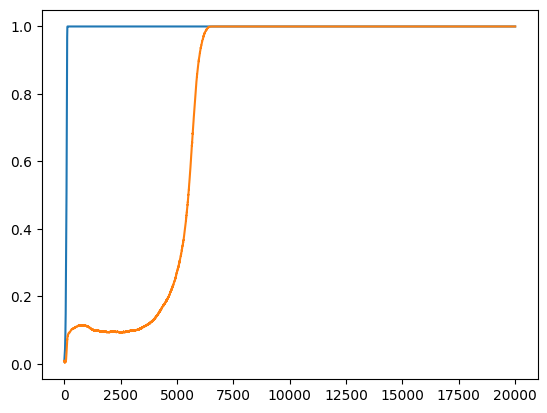

In [15]:
plt.plot(train_accs)
plt.plot(test_accs)

<Figure size 640x480 with 0 Axes>

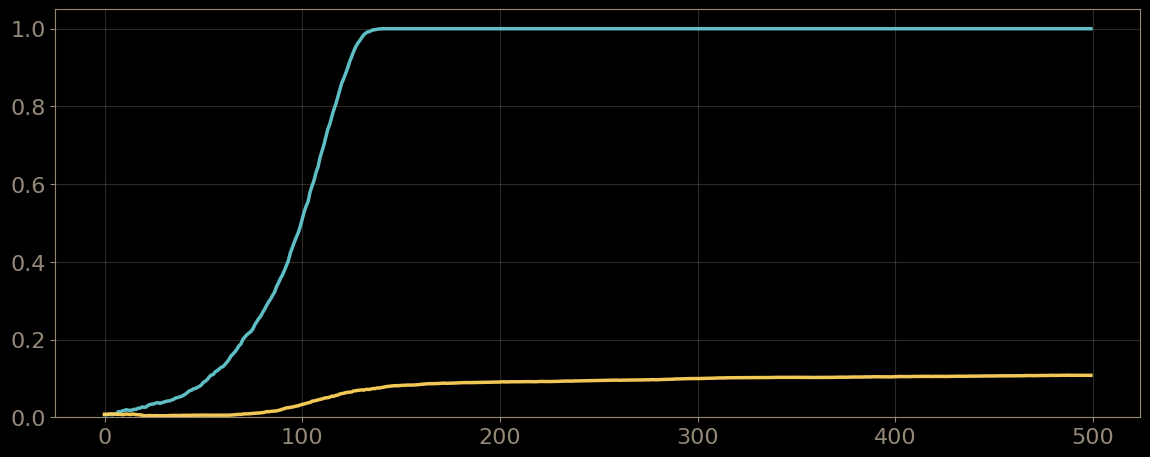

In [16]:
plt.clf()        
fig=plt.figure(0,(14,6), facecolor='k') 
ax=fig.add_subplot(111, facecolor='k')

plt.plot(train_accs[:500], c=BLUE, linewidth=2.5, alpha=0.95) #'#dfd0b9')
plt.plot(test_accs[:500], c=YELLOW, linewidth=2.5, alpha=0.95) #'#dfd0b9')
plt.tick_params(axis='x', colors='#948979', labelsize=16)  # Add labelsize here
plt.tick_params(axis='y', colors='#948979', labelsize=16)  # Add labelsize here

plt.gca().spines['top'].set_color('#948979')
plt.gca().spines['bottom'].set_color('#948979')
plt.gca().spines['left'].set_color('#948979')
plt.gca().spines['right'].set_color('#948979')
plt.subplots_adjust(bottom=0.2)  # Add fixed bottom margin
# plt.xlim([-10, len(to_plot)+10])
plt.ylim([0,1.05]) #Bad idea to fix or is it fine?
plt.grid(True, color='#948979', alpha=0.3)

<Figure size 640x480 with 0 Axes>

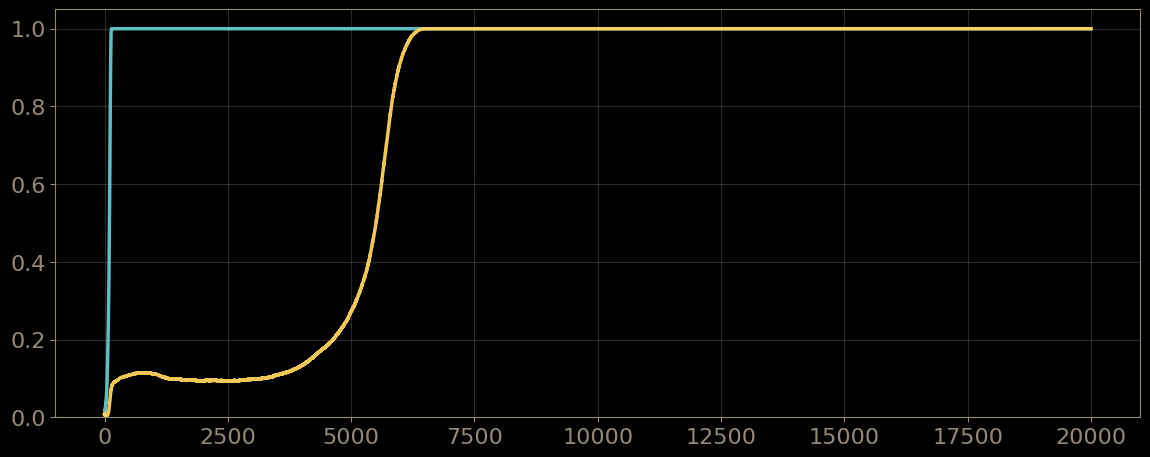

In [17]:
plt.clf()        
fig=plt.figure(0,(14,6), facecolor='k') 
ax=fig.add_subplot(111, facecolor='k')

plt.plot(train_accs, c=BLUE, linewidth=2.5, alpha=0.95) #'#dfd0b9')
plt.plot(test_accs, c=YELLOW, linewidth=2.5, alpha=0.95) #'#dfd0b9')
plt.tick_params(axis='x', colors='#948979', labelsize=16)  # Add labelsize here
plt.tick_params(axis='y', colors='#948979', labelsize=16)  # Add labelsize here

plt.gca().spines['top'].set_color('#948979')
plt.gca().spines['bottom'].set_color('#948979')
plt.gca().spines['left'].set_color('#948979')
plt.gca().spines['right'].set_color('#948979')
plt.subplots_adjust(bottom=0.2)  # Add fixed bottom margin
# plt.xlim([-10, len(to_plot)+10])
plt.ylim([0,1.05]) #Bad idea to fix or is it fine?
plt.grid(True, color='#948979', alpha=0.3)

In [18]:
from tqdm import tqdm

In [19]:
all_data = torch.tensor([(i, j, p) for i in range(p) for j in range(p)]).to('cuda')
labels = torch.tensor([fn(i, j) for i, j, _ in all_data]).to('cuda')
cache = {}
model.remove_all_hooks()
model.cache_all(cache)
# Final position only
original_logits = model(all_data)[:, -1]
# Remove equals sign from output logits
original_logits = original_logits[:, :-1]
original_loss = cross_entropy_high_precision(original_logits, labels)
print(f"Original loss: {original_loss.item()}")

#Ok let's try pre -> the og. 
mr = einops.rearrange(cache['blocks.0.mlp.hook_pre'], "(x y) ... -> x y ...", x=p).detach().cpu().numpy() 

Original loss: 2.2903962260483134e-07


In [20]:
# ---- Helper for classifying term type ----
def classify_term_type(kx, ky, is_dc):
    if is_dc:
        return "dc"
    if kx != 0 and ky == 0:
        return "row"
    if kx == 0 and ky != 0:
        return "col"
    if kx == 0 and ky == 0:
        return "dc"
    return "cross"  # kx != 0 and ky != 0


# ---- Loop over neurons and build DataFrame ----
all_rows = []

for neuron_idx in tqdm(range(512)):
    # 113 x 113 slice for this neuron
    m_slice = mr[:, :, 2, neuron_idx]

    components, Nx, Ny = compute_frequency_components(m_slice)
    terms = components_to_terms(components, Nx, Ny, num_freqs=4, include_dc=True)

    # Max amplitude (non-DC) for this neuron, for "strong" comparison later
    non_dc_terms = [t for t in terms if not t.get("is_dc", False)]
    max_amp = max((t["amplitude"] for t in non_dc_terms), default=0.0)

    for rank, t in enumerate(terms):
        is_dc = t.get("is_dc", False)
        kx = t["kx"]
        ky = t["ky"]
        amp = t["amplitude"]
        phase = t["phase"]

        term_type = classify_term_type(kx, ky, is_dc)

        all_rows.append({
            "neuron_idx": neuron_idx,
            "term_rank": rank,          # 0 = DC if include_dc=True
            "is_dc": is_dc,
            "term_type": term_type,     # "dc", "row", "col", "cross"
            "kx": kx,
            "ky": ky,
            "amplitude": amp,
            "phase": phase,
            "max_amp_neuron": max_amp,  # per neuron
        })

df = pd.DataFrame(all_rows)
df['relative_amplitude']=df['amplitude']/df['max_amp_neuron']

100%|██████████████████████| 512/512 [00:18<00:00, 27.23it/s]


In [21]:
df['kx'].value_counts()

kx
0     1219
27     546
3      256
9      239
54     111
1      103
2       59
6       21
18       6
Name: count, dtype: int64

In [28]:
dff=df[df['kx']==3]
dff=dff[dff['ky']==3]

In [29]:
dff.sort_values(by='relative_amplitude', ascending=False)[:15]

,neuron_idx,term_rank,is_dc,term_type,kx,ky,amplitude,phase,max_amp_neuron,relative_amplitude
1996,399,1,False,cross,3,3,0.056014,1.574187,0.056014,1.000000
1926,385,1,False,cross,3,3,0.014520,-2.136697,0.014520,1.000000
331,66,1,False,cross,3,3,0.044015,1.295013,0.044015,1.000000
341,68,1,False,cross,3,3,0.057832,1.679788,0.057832,1.000000
2007,401,2,False,cross,3,3,0.051571,1.408857,0.055094,0.936055
1947,389,2,False,cross,3,3,0.033715,1.539971,0.037488,0.899353
404,80,4,False,cross,3,3,0.033335,1.297555,0.049708,0.670611
552,110,2,False,cross,3,3,0.019029,1.517555,0.029894,0.636555
938,187,3,False,cross,3,3,0.018268,1.826596,0.035365,0.516566
1168,233,3,False,cross,3,3,0.017440,1.571999,0.035920,0.485509


In [33]:
neuron_idx=385
FT = np.fft.fft2(mr[:,:,2,neuron_idx])

components, Nx, Ny = compute_frequency_components(mr[:,:,2,neuron_idx])
terms = components_to_terms(components, Nx, Ny, num_freqs=4, include_dc=True)
code_str = generate_python_reconstructor(terms, Nx, Ny,
                                         func_name="approx_M",
                                         decimals=3)
print(code_str)

def approx_M(i, j):
    val = 0.052
    val += 0.015 * np.cos(2*np.pi*((3*i)/113) + -2.137) * np.cos(2*np.pi*((3*j)/113) + -2.137)
    val += 0.01 * np.cos(2*np.pi*((6*j)/113) + 0.872)
    val += 0.01 * np.cos(2*np.pi*((6*i)/113) + 0.872)
    val += 0.009 * np.cos(2*np.pi*((3*i)/113) + 0.0) * np.cos(2*np.pi*((110*j)/113) + 0.0)
    return val


In [34]:
def approx_M(i, j):
    val = 0.052
    val += 0.015 * np.cos(2*np.pi*((3*i)/113) + -2.137) * np.cos(2*np.pi*((3*j)/113) + -2.137)
    val += 0.01 * np.cos(2*np.pi*((6*j)/113) + 0.872)
    val += 0.01 * np.cos(2*np.pi*((6*i)/113) + 0.872)
    val += 0.009 * np.cos(2*np.pi*((3*i)/113) + 0.0) * np.cos(2*np.pi*((110*j)/113) + 0.0)
    return val

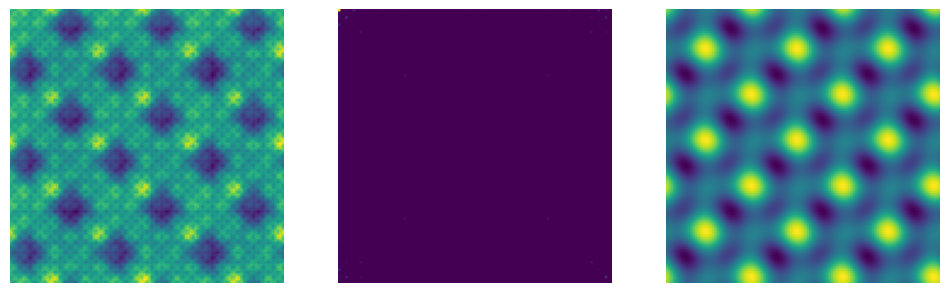

In [35]:
m_approx=np.zeros((p,p))
for i in range(p):
    for j in range(p):
        m_approx[i,j]=approx_M(i,j)

fig=plt.figure(0, (12, 6))
fig.add_subplot(1,3,1); plt.imshow(mr[:,:,2,neuron_idx]); plt.axis('off')
fig.add_subplot(1,3,2); plt.imshow(np.abs(FT));  plt.axis('off')
fig.add_subplot(1,3,3); plt.imshow(m_approx); plt.axis('off');

In [27]:
run_name

'grok_1764706128'